In [1]:
#imports
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
import jinja2

reading the dataset

In [2]:
def read_csv(file_path,has_header):
    """this function is used for taking the dataset from .csv file making a test train split
    and x, y split (has header is either True or False)"""

    #reading the .csv
    if has_header:
        df = pd.read_csv(file_path, header=0, delimiter=",")  # First row as header
        print(f"Dataset shape: {df.shape}")
        print(f"Column names: {list(df.columns)}")
    else:
        df = pd.read_csv(file_path, header=None, delimiter=",")  # No header row
        print(f"Dataset shape: {df.shape}")
    
    return df


selecting the dataset

In [3]:
dataset_name= "beans"
df = read_csv(dataset_name + "_kmeans.csv", True)
label_column = 16
number_of_sets = 4

Dataset shape: (13611, 17)
Column names: ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class']


dataset_name= "diabetes"
df = read_csv(dataset_name + "_kmeans.csv", True)
label_column = 8
number_of_sets = 3

dataset_name= "divorce"
df = read_csv(dataset_name + ".csv", True)
label_column = 54
number_of_sets = 14

dataset_name= "parkinsons"
df = read_csv(dataset_name + "_kmeans.csv", True)
df = df.drop(columns = 'name')
label_column = 16
number_of_sets = 6

dataset_name= "rice"
df = read_csv(dataset_name + "_binned_kmeans.csv", True)
label_column = 7
number_of_sets = 2

dataset_name= "wdbc"
df = read_csv(dataset_name + "_binned_kmeans.csv", True)
df = df.drop(columns = 'ID')
label_column = 0
number_of_sets = 8

making string columns numeric

In [4]:
# Find all string/object columns automatically
string_columns = df.select_dtypes(include=['object']).columns

# Encode all string columns
for column in string_columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])

mi for all features (graph)

In [5]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


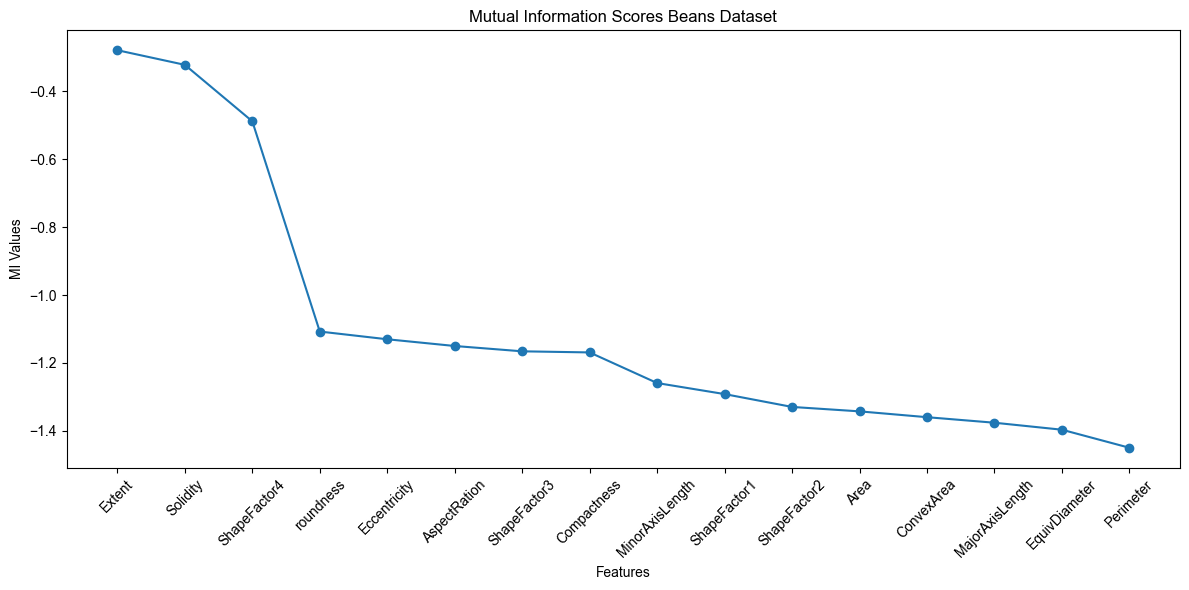

In [6]:
def mi_for_all(df_name = df, lc = label_column, title = 'complete dataset'):
    y = df_name.iloc[:, lc]
    #print(f'label is {y}')
    x = df_name.drop(df_name.columns[lc], axis=1)
    mi_scores = mutual_info_classif(x, y, discrete_features=True)
    mi_scores= mi_scores / np.log(2)



    #   ********   multiplied with -1 for the elbow method graphs
    mi_scores= mi_scores * -1

    
    mi_df = pd.DataFrame({"Feature": x.columns, "MI_Score": mi_scores}).sort_values(by="MI_Score", ascending=False)




    # Create line plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(mi_df["Feature"], mi_df["MI_Score"], marker='o')
    ax.set_xlabel("Features")
    ax.set_ylabel("MI Values")
    ax.set_title(f"Mutual Information Scores {dataset_name.title()} Dataset")
    plt.style.use('seaborn-v0_8')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'mi {dataset_name} {title}.png', dpi=300, bbox_inches='tight')
    plt.show()


    return x,y,mi_df

x,y,mi_df= mi_for_all()
mi_df.to_latex(f'{dataset_name}_mi.tex', index=True, float_format='%.6f')



vertical split

# Target columns count (divide into 3 parts, take integer)
#total_columns = df.shape[1]
#target_columns_count = total_columns // 3
# Pick random feature columns from total number of columns from dataset x
#random.seed(42)
#random_cols = random.sample(range(x.shape[1]), target_columns_count - 1)
# Build target_set (label first, then random features)
#target_features = x.iloc[:, random_cols]
#target_set = pd.concat([y, target_features], axis=1)
#remaining_set = x.drop(x.columns[random_cols], axis=1)
#print("Target columns count:", target_columns_count)
#print("Selected feature indices:", random_cols)
#print(target_set.head(), "\n")
#print(remaining_set.head())

# Split the feature indices into groups
parts = np.array_split(np.arange(df.shape[1]), number_of_sets, axis=0)

# Get the first group of feature indices
#target_feature_indices = parts[0]

# Select the target features using column indices
#target_features = x.iloc[:, target_feature_indices]

# Create target set by concatenating y with target features
#target_set = pd.concat([y, target_features], axis=1)
print("Parts:")
for i, part in enumerate(parts):
    print(f"Part {i}: {part}")

target_set = None

# Find which part has the label column and get that part
for part in parts:
    if label_column in part:
        target_set = df.iloc[:, part]
        break

if target_set is not None:
    print(f"Target set shape: {target_set.shape}")
else:
    print(f"Label column {label_column} not found in any part")



#make label first column on target_set and the last column will be the lowst mi on target_set
label_col = df.columns[label_column]
col_data = target_set.pop(label_col)  # Remove the column
target_set.insert(0, label_col, col_data)  # Insert it at position 0


# Create remaining set by dropping the target feature columns
#remaining_set = x.drop(x.columns[target_feature_indices], axis=1)

#print("Selected feature indices:", target_feature_indices)

#print("Remaining set shape:", remaining_set.shape)
#print(remaining_set.head())


mi on the set with label to find the target (lowest mi)

# Get MI scores and find lowest MI column
a,b,target_mi_df = mi_for_all(df_name=target_set, lc=0, title = 'in target set')

lowest_mi_column = target_mi_df.iloc[-1]['Feature']
print(f"Column with lowest MI: {lowest_mi_column}")

# Calculate Spearman correlations
lowest_mi_data = target_set[lowest_mi_column]
print(f"lowest_mi_data:{lowest_mi_data}")

#x_ranked = x.rank(method='average').astype(int)
#lowest_mi_ranked = lowest_mi_data.rank(method='average').astype(int)

correlations = x.corrwith(lowest_mi_data, method='spearman')

# Convert to DataFrame and sort
mi_df = pd.DataFrame({
    'Feature': correlations.index,
    'Spearman_Correlation': correlations.abs().values
}).sort_values('Spearman_Correlation', ascending=False)

# Remove the column that correlates with itself
mi_df = mi_df[mi_df['Feature'] != lowest_mi_column]


print(f"Spearman correlations between '{lowest_mi_column}' and x:")
print(mi_df)

# Create line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mi_df["Feature"], corr_df["Spearman_Correlation"], marker='o')
ax.set_xlabel("Features")
ax.set_ylabel("Abs. Corrolation Values")
ax.set_title(f"Target= {lowest_mi_column} Feature Corrolations {dataset_name.title()} Dataset")
plt.style.use('seaborn-v0_8')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{dataset_name} spearman correlation.png', dpi=300, bbox_inches='tight')
plt.show()

corr_df.to_latex(f'{dataset_name}_corr.tex', index=True, float_format='%.6f')

corr_df['Spearman_Correlation'] = corr_df['Spearman_Correlation'].diff(-1)
corr_df['Spearman_Correlation'] = corr_df['Spearman_Correlation'] +1
print(corr_df)
corr_df['Spearman_Correlation'] = corr_df['Spearman_Correlation'] / corr_df['Spearman_Correlation'].shift(1)

corr_df['Spearman_Correlation'] = corr_df['Spearman_Correlation'] -1
corr_df['Spearman_Correlation'] = corr_df['Spearman_Correlation'] * 100

print(corr_df)

OLD LOGIC

#mi_df['MI_Score'] = mi_df['MI_Score'] * -1

mi_df['MI_Score'] = mi_df['MI_Score'].diff(-1)
mi_df['MI_Score'] = mi_df['MI_Score'] +1
print(mi_df)
mi_df['MI_Score'] = mi_df['MI_Score'] / mi_df['MI_Score'].shift(1)

mi_df['MI_Score'] = mi_df['MI_Score'] -1
mi_df['MI_Score'] = mi_df['MI_Score'] * 100

print(mi_df)

In [7]:
mi_df = mi_df.reset_index(drop=True)
mi_df['diffrence'] = mi_df['MI_Score'].diff(1)
mi_df['change'] = mi_df['diffrence'].diff(1)
print(mi_df)
mi_df['change 2'] = -mi_df['change'] + 1
print(mi_df)
drop_idx = np.argmax(-mi_df['change']) + 1  # +1 because diff reduces length
print(drop_idx)

            Feature  MI_Score  diffrence    change
0            Extent -0.278611        NaN       NaN
1          Solidity -0.321727  -0.043116       NaN
2      ShapeFactor4 -0.488105  -0.166378 -0.123262
3         roundness -1.107701  -0.619596 -0.453218
4      Eccentricity -1.130443  -0.022741  0.596855
5      AspectRation -1.150275  -0.019832  0.002909
6      ShapeFactor3 -1.165966  -0.015691  0.004142
7       Compactness -1.169233  -0.003267  0.012424
8   MinorAxisLength -1.259459  -0.090226 -0.086959
9      ShapeFactor1 -1.291987  -0.032527  0.057699
10     ShapeFactor2 -1.329859  -0.037872 -0.005345
11             Area -1.342918  -0.013059  0.024813
12       ConvexArea -1.360073  -0.017155 -0.004096
13  MajorAxisLength -1.376408  -0.016335  0.000820
14    EquivDiameter -1.396991  -0.020583 -0.004248
15        Perimeter -1.450173  -0.053182 -0.032599
            Feature  MI_Score  diffrence    change  change 2
0            Extent -0.278611        NaN       NaN       NaN
1          

In [8]:
"""#mi_df['MI_Score'] = mi_df['MI_Score'] * -1
print(mi_df)

mi_df = mi_df.reset_index(drop=True)
mi_df['diffrence'] = mi_df['MI_Score'].diff(-1)
#mi_df['MI_Score'] = mi_df['MI_Score'] +1
print(mi_df)

mi_df['ratio'] = mi_df['diffrence'].shift(-1) / mi_df['diffrence']

#mi_df['MI_Score'] = mi_df['MI_Score'] -1
#mi_df['MI_Score'] = mi_df['MI_Score'] * 100

print(mi_df)
"""

df_excel = mi_df.copy()

# Flatten MultiIndex columns
if isinstance(df_excel.columns, pd.MultiIndex):
    df_excel.columns = ["_".join(map(str, c)) for c in df_excel.columns]

# Preserve index if meaningful
df_excel = df_excel.reset_index()

df_excel.to_excel(
    "diff.xlsx",
    sheet_name="beans",
    index=False,
    float_format="%.10f"
)